**Tinkoff Lab. Лабораторная работа "DeepFake"**

*Disclaimer. Весь код ниже -- результат нескольких дней и ночей страданий, борьбы с зависимостями и багами той ужасной библиотеки, что я выбрала. Тем не менее, я ни о чём не жалею и крайне довольна результатом, даже если он покажется очень скромным.*

В задании предлагается решить задачу семантической сегментации атрибутов лица человека. В качестве датасета будет использоваться [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ). Сам датасет довольно большой (30к фотографий), поэтому, для ускорения разработки решения предлагается использовать только часть (5к фотографий) - разбиение на train/test, а также имена фотографий (соответствующие именам в CelebA-HQ-img) находятся в файле [`train_test_split.csv`](https://edu.tinkoff.ru/files/10e5aa2b-26ae-4110-b7a6-2beed2c7da6a). Также, для ускорения экспериментов, предлагается привести фотографии к разрешению 512x512 (оригинальное разрешение 1024x1024).

Сразу стоит отметить, что решение предложенной задачи даже на ограниченном датасете в ограниченном качестве требует совершенно неприличных вычислительных мощностей, которыми я не владею, к сожалению. Так как лучшее, что у меня есть, это Google Colab, в своём датасете я сжала картинки до 128 на 128. Тут, конечно, и речи быть не может о сегментации глаз или верхних губ, но поучиться выдялеть лицо или волосы с некоторым успехом можно. К тому же, модель масштабируемая, и при желании можно испытать её на большом количестве классов и высоком качестве картинок.

Итак, моя любимая ml-библиотека:

In [20]:
# для колаба
# !pip install -U segmentation-models==1.0.1


import segmentation_models as smp
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

In [58]:
import os
import torch
import matplotlib.pyplot as plt

from pprint import pprint
from torch.utils.data import DataLoader

In [54]:
# для колаба

# import shutil
# shutil.unpack_archive("/content/drive/MyDrive/CelebAMask.tar.gz", "/content/")

Просто извлекаем изображения из папок

In [47]:
import numpy as np
from PIL import Image


def get_images(images_dir, masks_dir, cl):
  imgs = []
  masks = []
  loader = []
  masks_ids = os.listdir(masks_dir)
  for file_ in os.listdir(images_dir):
    image = Image.open(images_dir + file_)
    image = np.array(image).astype('float32')

    mask_name = file_.split('.')[0].zfill(5) + '_' + cl + '.png'
    if mask_name in masks_ids:
      mask = Image.open(masks_dir + mask_name)
      mask = (np.expand_dims(np.array(mask)[:,:,0], -1) / 255).astype('float32')
    else:
      mask = (np.zeros((128, 128, 1)))

    imgs.append(image)
    masks.append(mask)
    loader.append([image, mask])
  return imgs, masks, loader

Классифицировать будем по одному классу, так будет надежда получить результат до второго пришествия. Какой класс выбрать? Лицо -- слишком просто, глаза -- крайне трудно при таком разрешении, уши -- не видны на половине фотографий и обучающий датасет окажется сильно урезанным. Выбираем волосы!

In [48]:
import os

CLASS = 'hair' # волосы!

X_train, y_train, train_data = get_images('CelebAMask/train_img/', 'CelebAMask/train_mask/', CLASS)
X_test, y_test, test_data = get_images('CelebAMask/test_img/', 'CelebAMask/test_mask/', CLASS)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

n_cpu = os.cpu_count()

Train size: 3750
Test size: 1250


In [49]:
train_data[0][1].shape

(128, 128, 1)

Пример изображений и их масок. При сжатии края маски оказались немного размыты.

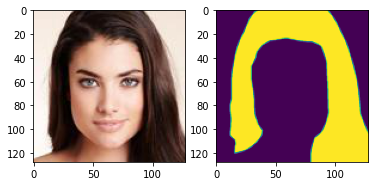

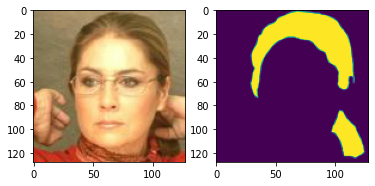

In [50]:

plt.subplot(1,2,1)
plt.imshow(X_train[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(np.array(y_train[0])[:,:,0])
plt.show()


plt.subplot(1,2,1)
plt.imshow(X_test[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(np.array(y_test[0])[:,:,0])
plt.show()

Пришлось написать свой маленький даталоадер.

In [51]:
from tensorflow.keras.utils import Sequence

class Dataloder(Sequence):

  def __init__(self, dataset, batch_size=1, shuffle=False):
      self.dataset = dataset
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.indexes = np.arange(len(dataset))

      self.on_epoch_end()

  def __getitem__(self, i):
      
      # collect batch data
      start = i * self.batch_size
      stop = (i + 1) * self.batch_size
      data = []
      for j in range(start, stop):
          data.append(self.dataset[j])
      
      # transpose list of lists
      batch = [np.stack(samples, axis=0) for samples in zip(*data)]
      
      # newer version of tf/keras want batch to be in tuple rather than list
      return tuple(batch)

  def __len__(self):
    """Denotes the number of batches per epoch"""
    return len(self.indexes) // self.batch_size

  def on_epoch_end(self):
    """Callback function to shuffle indexes each epoch"""
    if self.shuffle:
        self.indexes = np.random.permutation(self.indexes)


train_loader = Dataloder(train_data, 16, True)
test_loader = Dataloder(test_data, 16, False)

Непосредственно нейросеть. Для начала попробуем архитектуру Unet . В качестве оптимизатора Adam, лосс -- Diceloss, как требуется в задании. Из приятного, в модель загружаются предобученные веса `imagenet`.

In [53]:
import segmentation_models as sm

sm.set_framework('tf.keras')

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)


# preprocess input
train_loader = preprocess_input(train_loader)
test_loader = preprocess_input(test_loader)

# define model
model = Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=dice_loss, metrics=[iou_score])

# fit model
model.fit(
    train_loader,
    batch_size=16,
    epochs=5,
    validation_data=test_loader,
)

Epoch 1/5
234/234 [==============================] - 1533s 7s/step - loss: 0.1516 - iou_score: 0.7446 - val_loss: 0.1343 - val_iou_score: 0.7647
Epoch 2/5
234/234 [==============================] - 1521s 7s/step - loss: 0.1001 - iou_score: 0.8189 - val_loss: 0.1107 - val_iou_score: 0.8014
Epoch 3/5
234/234 [==============================] - 1520s 6s/step - loss: 0.0894 - iou_score: 0.8364 - val_loss: 0.0975 - val_iou_score: 0.8231
Epoch 4/5
234/234 [==============================] - 1519s 6s/step - loss: 0.0831 - iou_score: 0.8471 - val_loss: 0.1056 - val_iou_score: 0.8100
Epoch 5/5
234/234 [==============================] - 1518s 6s/step - loss: 0.0795 - iou_score: 0.8533 - val_loss: 0.0940 - val_iou_score: 0.8289


In [55]:
model.save('model.pth')

INFO:tensorflow:Assets written to: model.pth/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Спустя пару часов, имеем такой результат:

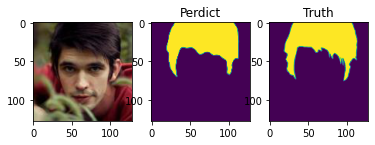

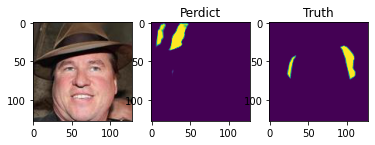

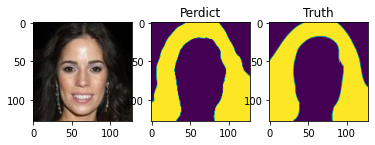

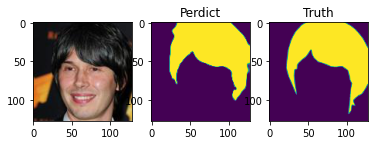

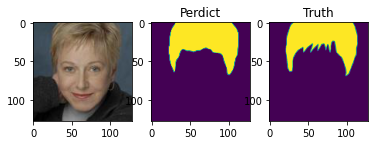

In [57]:
for i in range(5):
    n = np.random.choice(len(test_data))
    
    image, gt_mask = test_data[n]
    
    pr_mask = model.predict(np.expand_dims(image, axis=0))

        
    plt.subplot(1,3,1)
    plt.imshow(image.astype('uint8')) # for visualization we have to transpose back to HWC
    plt.subplot(1,3,2)
    plt.imshow(pr_mask[0,:,:,0])  # for visualization we have to remove 3rd dimension of mask
    plt.title("Perdict")
    plt.subplot(1,3,3)
    plt.imshow(gt_mask[:,:,0])  # for visualization we have to remove 3rd dimension of mask
    plt.title("Truth")
    plt.show()


Как видно, для большинства простых случаев, когда волос много, модель справляется неплохо, но конечно недостаточно детально. Есть надежда, что если пообучать её еще несколько десятков эпох, получится достойный применения результат.

**Небольшой вывод о проделанной работе**

В общем и целом, основная работа заключалась в том, чтобы разобраться в работе библиотеки, и это в конечном итоге удалось. Заметно, что обучение происходит, и для такой сложной задачи относительно быстро, без предобучения за такое время вряд ли можно было бы получить что-то подобное. В соседних ноутбуках учатся другие архитектуры, но, конечно, такого поверхностного исследования не хватит, чтобы найти разницу между ними.

***Продолжение, пока осталось время***

In [ ]:
model.fit(
    train_loader,
    batch_size=16,
    epochs=5,
    validation_data=test_loader,
)

Epoch 1/5
177/234 [=====================>........] - ETA: 5:48 - loss: 0.0732 - iou_score: 0.8639